In [2]:
import jax
import optax
import numpy as np
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from typing import Callable
from functools import partial
from jax.flatten_util import ravel_pytree
from rebayes.utils.rotating_mnist_data import load_rotated_mnist, load_mnist

from rebayes import base
from rebayes.low_rank_filter import lofi
from rebayes.sgd_filter import replay_sgd as rsgd
from rebayes.utils.utils import tree_to_cpu, get_subtree

/home/kpmurphy/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-12 00:16:51.430507: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/kpmurphy/.local/lib/python3.8/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%config InlineBackend.figure_format = "retina"

In [5]:
class MLP(nn.Module):
    n_out: int = 1
    n_hidden: int = 100
    activation: Callable = nn.elu

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out, name="last-layer")(x)
        x = nn.sigmoid(x)
        return x


def load_data(
    anglefn: Callable,
    sort_by_angle: bool = True,
):
    data = load_rotated_mnist(
        anglefn, target_digit=[3, 2], sort_by_angle=sort_by_angle, num_train=10_000,
    )
    train, test = data
    X_train, y_train, labels_train = train
    X_test, y_test, labels_test = test

    ymean, ystd = y_train.mean().item(), y_train.std().item()

    y_train = (y_train - ymean) / ystd
    y_test = (y_test - ymean) / ystd

    dataset = {
        "train": (X_train, y_train, labels_train),
        "test": (X_test, y_test, labels_test),
    }

    res = {
        "dataset": dataset,
        "ymean": ymean,
        "ystd": ystd,
    }

    return res

In [6]:
def damp_angle(n_configs, minangle, maxangle):
    t = np.linspace(-0.5, 1.5, n_configs)
    
    angles = np.exp(t) * np.sin(55 * t)
    angles = np.sin(55 * t)
    
    angles = (angles + 1) / 2 * (maxangle - minangle) + minangle + np.random.randn(n_configs) * 2
    
    # angles = np.random.randn(n_configs) / 100
    # angles = np.abs(angles)
    
    return angles

100%|██████████| 9912422/9912422 [00:00<00:00, 118851926.45it/s]


Extracting /tmp/data/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 84651078.84it/s]


Extracting /tmp/data/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34571505.54it/s]

Extracting /tmp/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 32676721.73it/s]


Extracting /tmp/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/data/MNIST/raw



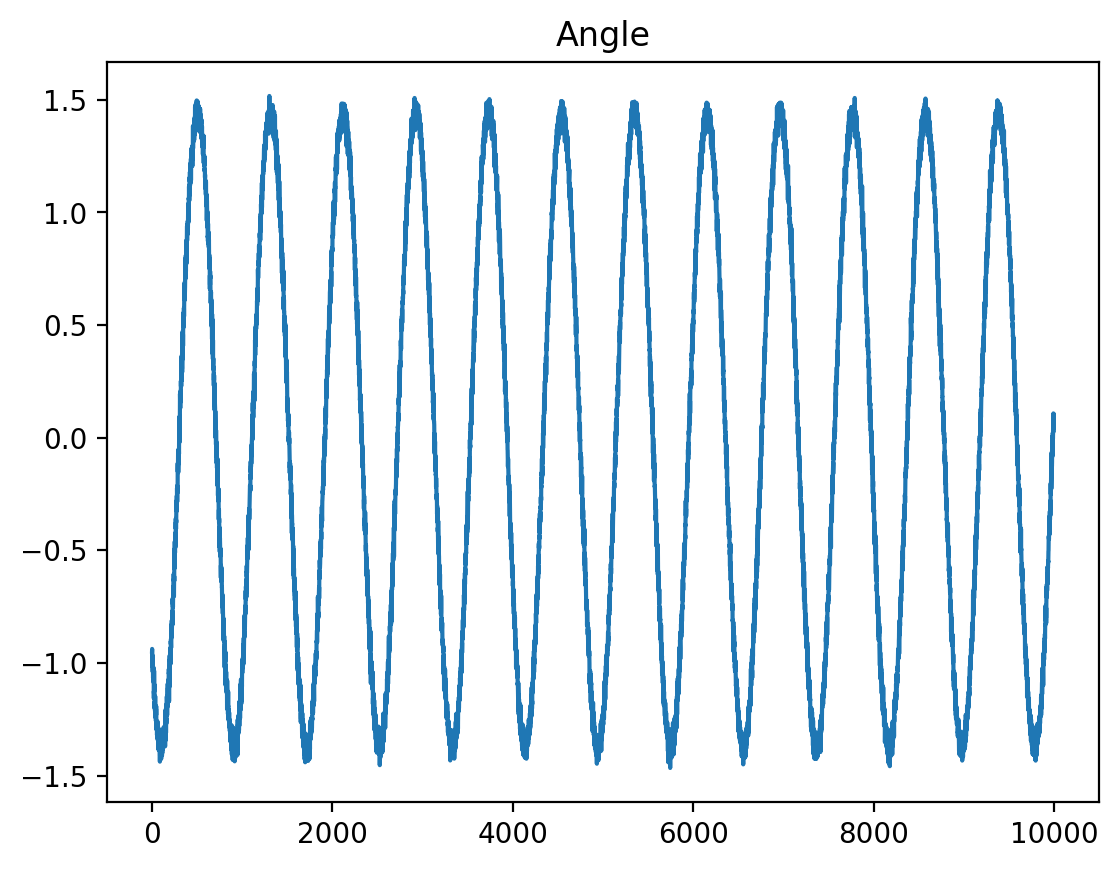

In [7]:
data = load_data(damp_angle, sort_by_angle=False)

X_train, signal_train, labels_train = data["dataset"]["train"]
X_test, signal_test, labels_test = data["dataset"]["test"]

plt.title("Angle")
plt.plot(signal_train)

In [8]:
Y_train = jnp.array(labels_train) == 2
y_train = jnp.array(labels_test) == 2

In [9]:
_, dim_in = data["dataset"]["train"][0].shape

In [10]:
def make_bnn_flax(dim_in, nhidden=50):
    key = jax.random.PRNGKey(314)
    dim_out = 1
    model = MLP(dim_out, nhidden)
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, recfn = ravel_pytree(params)
    n_params = len(flat_params)
    return model, params, flat_params, recfn

def apply_fn_flat(flat_params, x, model, recfn):
    return model.apply(recfn(flat_params), x)

def apply_fn_unflat(params, x, model):
    return model.apply(params, x)


model, dnn_params, flat_params, recfn = make_bnn_flax(dim_in)

def apply_fn_flat(flat_params, x, model, recfn):
    return model.apply(recfn(flat_params), x)

In [25]:
n_closest = 50
n_lb = 25

def callback(bel, pred_obs, t, X, y, bel_pred, apply_fn, store_fro=True, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    
    slice_ix = jnp.arange(0, 20) + t
    
    X_test = jnp.take(X_test, slice_ix, axis=0, fill_value=0)
    y_test = jnp.take(y_test, slice_ix, axis=0, fill_value=0)

    y_next = y.ravel()
    phat_next = pred_obs.ravel()
    yhat_next = phat_next.round()
    # eval on all tasks test set
    yhat_test = apply_fn(bel.mean, X_test).squeeze().round()

    # Compute errors
    err_test = (y_test == yhat_test).mean()
    err = (y_next == yhat_next).mean()
    
    if store_fro:
        mean_params = recfn(bel.mean)
        params_magnitude = jax.tree_map(lambda A: A["kernel"], mean_params, is_leaf=lambda k: "kernel" in k)
        params_magnitude = jax.tree_map(lambda A: jnp.linalg.norm(A, ord="fro"), params_magnitude)
    else:
        params_magnitude = None
    
    res = {
        "multi-step-error": err_test,
        "osa-error": err,
        "phat": phat_next,
        "params_magnitude": params_magnitude
    }
    return res

In [21]:
apply_fn = partial(apply_fn_flat, model=model, recfn=recfn)

ssm_params = base.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=0.1, # 0.01
        dynamics_weights=1,
        dynamics_covariance=0.0,#1e-3,
        emission_mean_function=apply_fn,
        emission_cov_function = lambda w, x: apply_fn(w, x) * (1 - apply_fn(w, x)) + 1e-3,
        dynamics_covariance_inflation_factor=0.0
)

mem = 10
lofi_params = lofi.LoFiParams(memory_size=mem, steady_state=False, inflation="hybrid")

In [22]:
print(X_train.shape, Y_train.shape)

(10000, 784) (10000,)


In [26]:
%%time
agent = lofi.RebayesLoFiDiagonal(ssm_params, lofi_params)

ymean, ystd = data["ymean"], data["ystd"]
callback_part = partial(callback,
                        apply_fn=agent.params.emission_mean_function,
                        X_test=X_train, y_test=Y_train,
                       )

bel, outputs = agent.scan(X_train, Y_train, progress_bar=False, callback=callback_part)
bel = jax.block_until_ready(bel)
outputs_lofi = tree_to_cpu(outputs)

CPU times: user 9.17 s, sys: 628 ms, total: 9.8 s
Wall time: 7.29 s


In [24]:
print(outputs_lofi)

{'multi-step-pred': array([0.35      , 0.8       , 0.65000004, ..., 0.15      , 0.1       ,
       0.05      ], dtype=float32), 'osa-error': array([1., 0., 1., ..., 1., 1., 1.], dtype=float32), 'params_magnitude': FrozenDict({
    params: {
        Dense_0: array([ 7.0871305,  7.089162 ,  7.090443 , ..., 10.979367 , 10.979398 ,
               10.979724 ], dtype=float32),
        Dense_1: array([7.1742363, 7.171534 , 7.172805 , ..., 7.698486 , 7.6985555,
               7.6986895], dtype=float32),
        Dense_2: array([7.0536313, 7.050709 , 7.052122 , ..., 7.237577 , 7.2376637,
               7.2379866], dtype=float32),
        last-layer: array([0.9619208 , 0.93790364, 0.94950616, ..., 0.91336703, 0.9134957 ,
               0.91379356], dtype=float32),
    },
}), 'phat': array([[5.2422583e-01],
       [6.9770670e-01],
       [4.4055209e-01],
       ...,
       [1.4855231e-05],
       [9.9417186e-01],
       [3.6975600e-02]], dtype=float32)}


Text(0.5, 1.0, 'Forecast error')

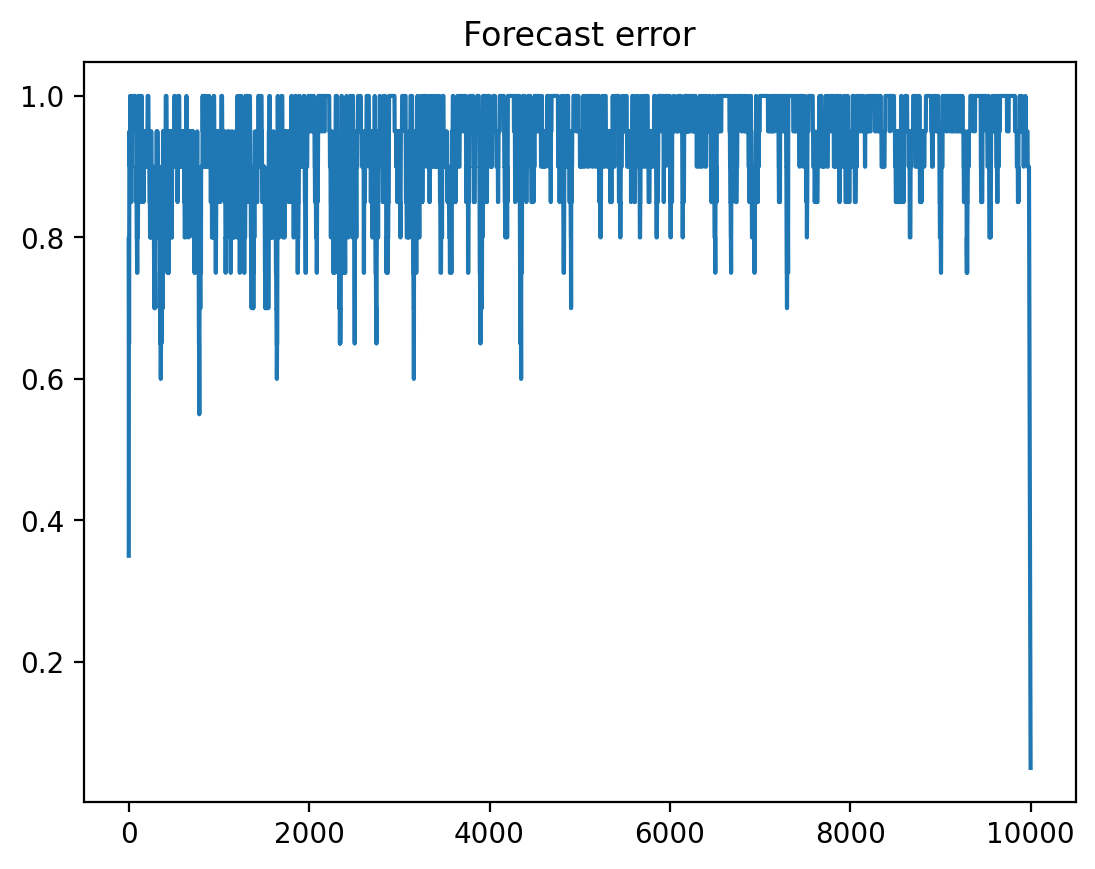

In [28]:
forecast_error = outputs_lofi["multi-step-error"]
plt.plot(forecast_error)
plt.title("Forecast error")

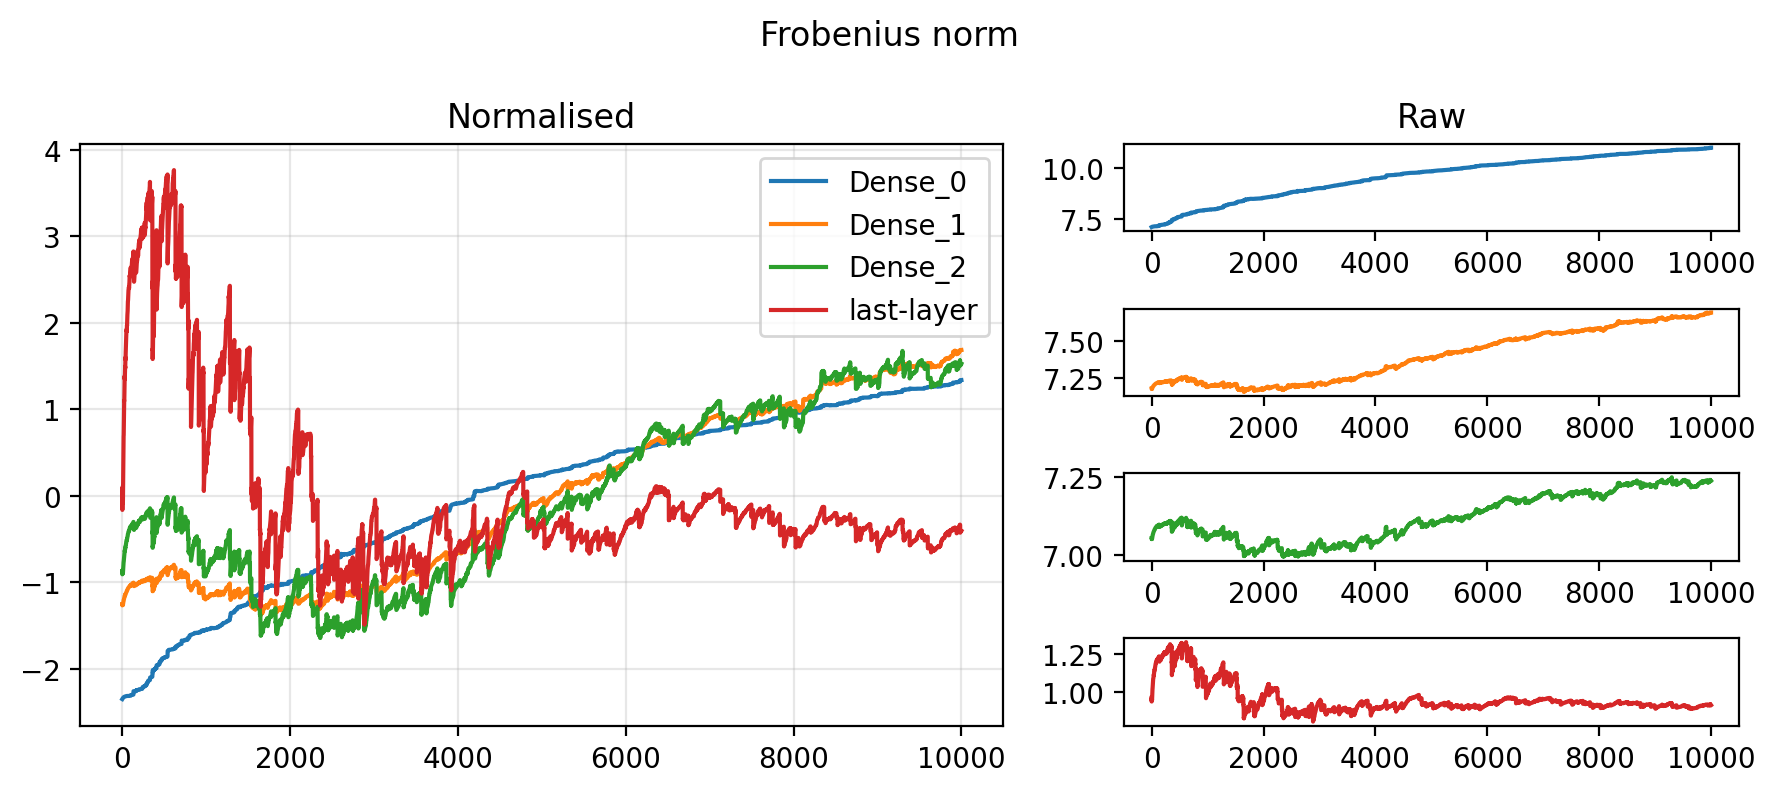

In [18]:


params_magnitude = outputs_lofi["params_magnitude"]["params"]
colors = plt.cm.tab10(np.arange(0, len(params_magnitude)))
# Create the figure and GridSpec
fig = plt.figure(figsize=(9, 4))

from matplotlib.gridspec import GridSpec

gs = GridSpec(nrows=4, ncols=2, figure=fig, width_ratios=[0.6, 0.4])

# Create the subplots
# Create the subplots
ax_main = fig.add_subplot(gs[:, 0])
for key, color in zip(params_magnitude, colors):
    v = params_magnitude[key]
    vnorm = (v - v.mean()) / v.std()
    ax_main.plot(vnorm, c=color, label=key)
ax_main.legend()

for i, key in enumerate(params_magnitude):
    ax = fig.add_subplot(gs[i, 1])
    if i == 0:
        ax.set_title("Raw")
    v = params_magnitude[key]
    ax.plot(v, color=colors[i])
plt.suptitle("Frobenius norm")
ax_main.grid(alpha=0.3)
ax_main.set_title("Normalised")
plt.tight_layout()

## Fifo Buffer

In [30]:
@partial(jax.jit, static_argnames=("apply_fn",))
def lossfn_rmse_fifo(params, counter, X, y, apply_fn):
    yhat = apply_fn(params, X).ravel()
    y = y.ravel()
    
    err = y * jnp.log(yhat) + (1 - y) * jnp.log(1 - yhat)
    loss = -(err * counter).sum() / counter.sum()
    return loss



## R-SGD
### SGD

In [31]:
lr, buffer = 1e-3, 10
agent = rsgd.FifoSGD(lossfn_rmse_fifo, 
                    apply_fn=partial(apply_fn_unflat, model=model),
                    init_params = dnn_params,
                    tx = optax.sgd(learning_rate=lr),
                    buffer_size = buffer,
                    dim_features = X_train.shape[1],
                    dim_output = 1,
                    n_inner=1)


In [1323]:
callback_part = partial(callback,
                        apply_fn=model.apply,
                        ymean=data["ymean"], ystd=data["ystd"],
                        X_test=X_test, y_test=y_test,
                        store_fro=False
                       )

bel, outputs = agent.scan(X_train, Y_train, progress_bar=True, callback=callback_part)
bel = jax.block_until_ready(bel)
outputs_rsgd = tree_to_cpu(outputs)

  0%|          | 0/10000 [00:00<?, ?it/s]

## R-SGD
### ADAM

In [1324]:
lr, buffer = 5e-4, 10
agent = rsgd.FifoSGD(lossfn_rmse_fifo, 
                    apply_fn=partial(apply_fn_unflat, model=model),
                    init_params = dnn_params,
                    tx = optax.adam(learning_rate=lr),
                    buffer_size=buffer,
                    dim_features=X_train.shape[1],
                    dim_output=1,
                    n_inner=1)


In [1325]:
callback_part = partial(callback,
                        apply_fn=model.apply,
                        ymean=data["ymean"], ystd=data["ystd"],
                        X_test=X_test, y_test=y_test,
                        store_fro=False,
                       )

bel, outputs = agent.scan(X_train, Y_train, progress_bar=True, callback=callback_part)
bel = jax.block_until_ready(bel)
outputs_rsgd_adam = tree_to_cpu(outputs)

  0%|          | 0/10000 [00:00<?, ?it/s]

## Agent comparisson

In [1326]:
ksize = 200
kernel = np.ones(ksize) / ksize

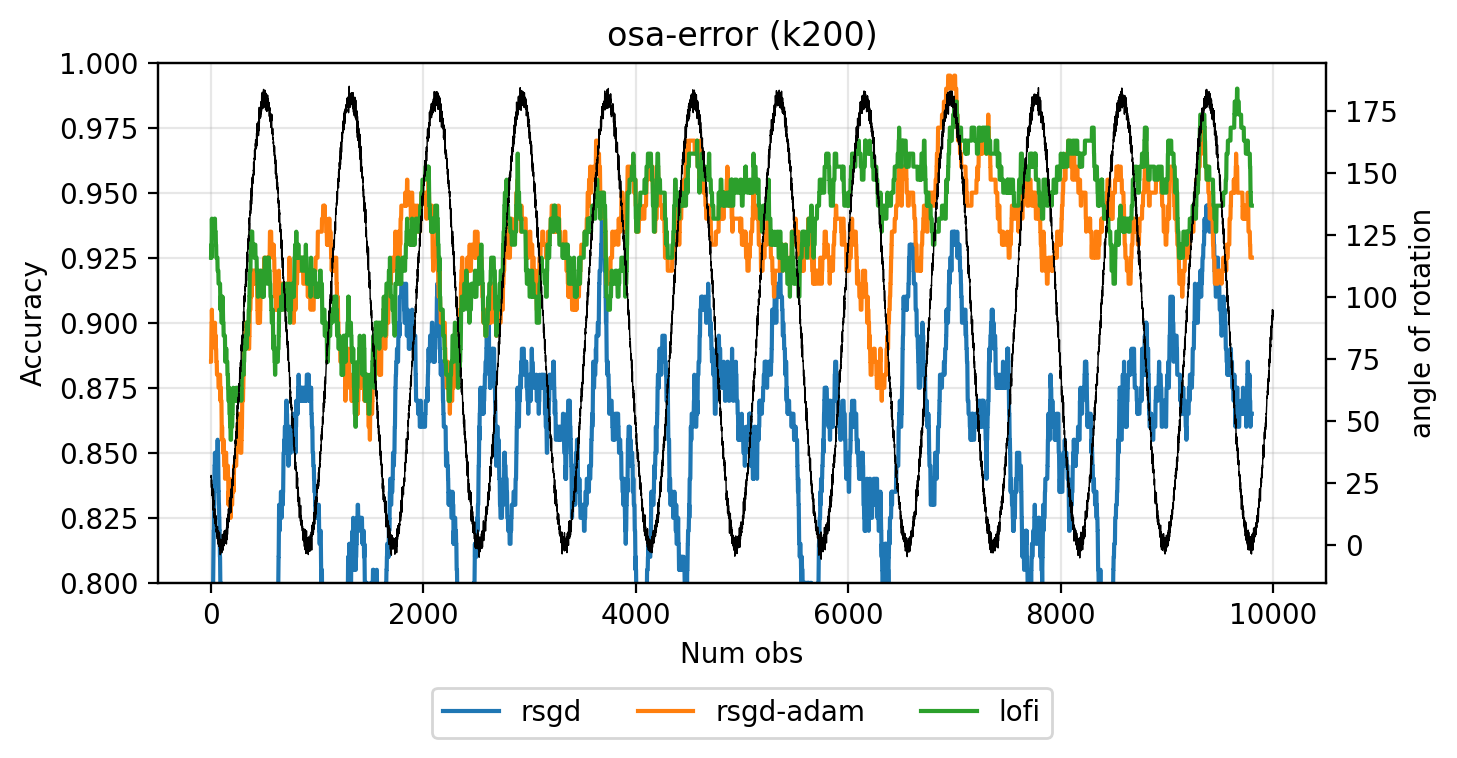

In [1327]:
stat = "osa-error"

fig, ax = plt.subplots(figsize=(7, 4))
ax2 = ax.twinx()
err_rsgd = outputs_rsgd[stat]
err_rsgd_adam = outputs_rsgd_adam[stat]
err_lofi = outputs_lofi[stat]

err_rsgd = np.convolve(err_rsgd, kernel, mode="valid")
err_rsgd_adam = np.convolve(err_rsgd_adam, kernel, mode="valid")
err_lofi = np.convolve(err_lofi, kernel, mode="valid")
keyv = f"osa-error (k{ksize})"

vmin, vmax = 0.8, 1.0

ax.plot(err_rsgd, label="rsgd")
ax.plot(err_rsgd_adam, label="rsgd-adam")
ax.plot(err_lofi, label="lofi")

angle_train = signal_train * ystd + ymean
ax2.plot(angle_train, linewidth=0.5, color="black", alpha=1)

ax.set_ylim(vmin, vmax)
ax.set_title(keyv)
ax.legend(fontsize=10, ncols=3, bbox_to_anchor=(0, 0, 1, -0.5), loc="center")
plt.tight_layout()

ax.set_ylabel("Accuracy")
ax2.set_ylabel("angle of rotation")
ax.set_xlabel("Num obs")

ax.grid(alpha=0.3)

Text(0.5, 0, 'Num. obs')

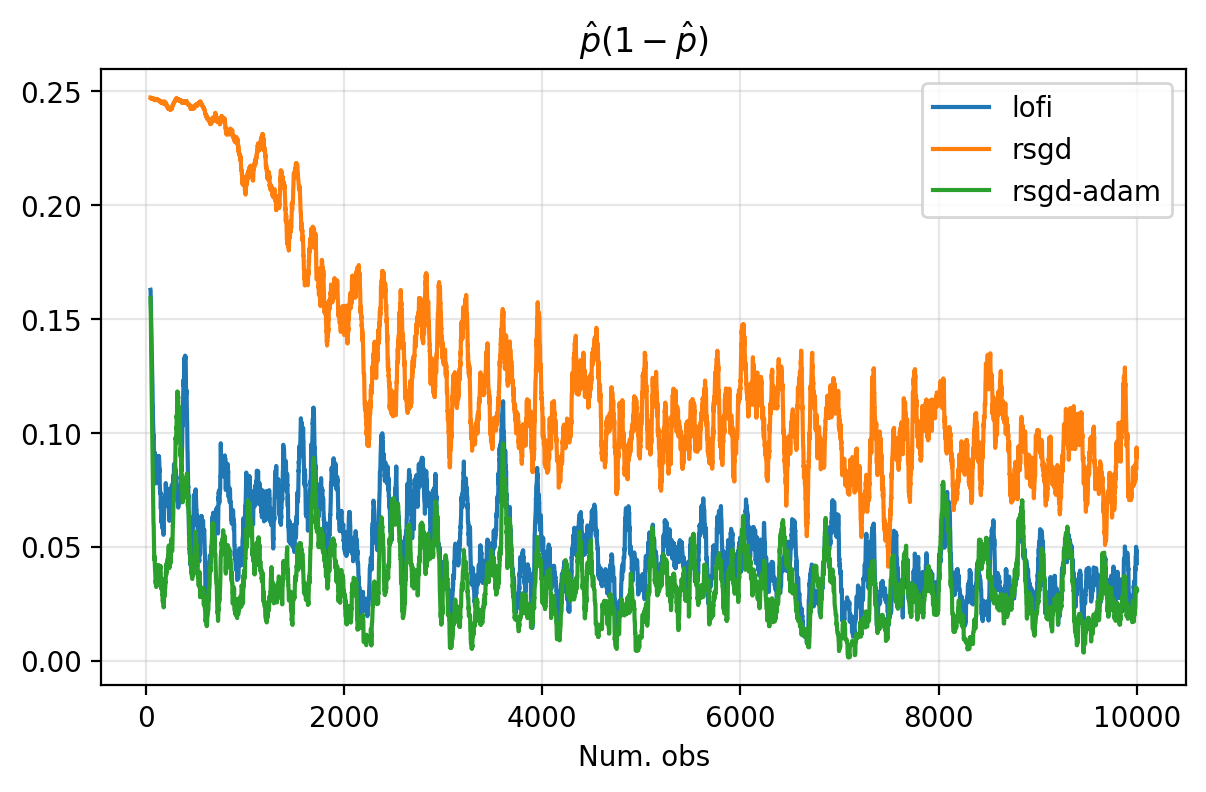

In [1328]:
stat = "phat"


cov_rsgd = outputs_rsgd[stat].ravel()
cov_rsgd = cov_rsgd * (1 - cov_rsgd)

cov_all = {
    "rsgd": outputs_rsgd[stat].ravel(),
    "rsgd-adam": outputs_rsgd_adam[stat].ravel(),
    "lofi": outputs_lofi[stat].ravel()
}

fig, ax = plt.subplots(figsize=(7, 4))
cov_all = pd.DataFrame(jax.tree_map(lambda p: p * (1 - p), cov_all))
cov_all.rolling(50).mean().plot(ax=ax)
plt.title("$\hat p (1 - \hat p)$")
plt.grid(alpha=0.3)
plt.xlabel("Num. obs")

In [1331]:
cov_all.corr()

,lofi,rsgd,rsgd-adam
lofi,1.000000,0.405520,0.573823
rsgd,0.405520,1.000000,0.306622
rsgd-adam,0.573823,0.306622,1.000000
